In [1]:
import heist
import helpers
import torch.distributions
import torch

import gym
import random
import numpy as np
from helpers import generate_action, load_model
import imageio
import matplotlib.pyplot as plt
import typing
import math

from procgen import ProcgenGym3Env
import struct
import typing
from typing import Tuple, Dict, Callable, List, Optional
from dataclasses import dataclass
from src.policies_modified import ImpalaCNN
from procgen_tools.procgen_wrappers import VecExtractDictObs, TransposeFrame, ScaledFloatFrame

from gym3 import ToBaselinesVecEnv
import seaborn as sns
import random

%load_ext autoreload
%autoreload 2

building procgen...

/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(
/Users/bensturgeon/mambaforge/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


done


In [2]:
ordered_layer_names = {
 0: 'conv_seqs',
 1: 'conv_seqs.0',
 2: 'conv_seqs.0.conv',
 3: 'conv_seqs.0.max_pool2d',
 4: 'conv_seqs.0.res_block0',
 5: 'conv_seqs.0.res_block0.conv0',
 6: 'conv_seqs.0.res_block0.conv1',
 7: 'conv_seqs.0.res_block1',
 8: 'conv_seqs.0.res_block1.conv0',
 9: 'conv_seqs.0.res_block1.conv1',
 10: 'conv_seqs.1',
 11: 'conv_seqs.1.conv',
 12: 'conv_seqs.1.max_pool2d',
 13: 'conv_seqs.1.res_block0',
 14: 'conv_seqs.1.res_block0.conv0',
 15: 'conv_seqs.1.res_block0.conv1',
 16: 'conv_seqs.1.res_block1',
 17: 'conv_seqs.1.res_block1.conv0',
 18: 'conv_seqs.1.res_block1.conv1',
 19: 'conv_seqs.2',
 20: 'conv_seqs.2.conv',
 21: 'conv_seqs.2.max_pool2d',
 22: 'conv_seqs.2.res_block0',
 23: 'conv_seqs.2.res_block0.conv0',
 24: 'conv_seqs.2.res_block0.conv1',
 25: 'conv_seqs.2.res_block1',
 26: 'conv_seqs.2.res_block1.conv0',
 27: 'conv_seqs.2.res_block1.conv1',
 28: 'hidden_fc',
 29: 'logits_fc',
 30: 'value_fc'
}


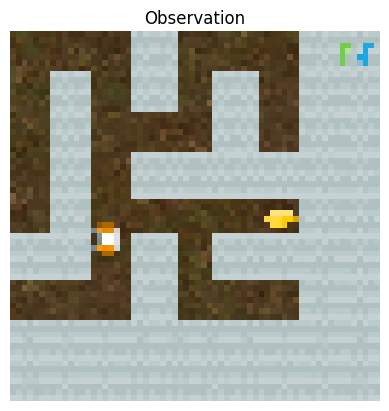

[]
[0.]
Count rewards 0 out of total episodes: 1/1


In [18]:
def run_gem_steering_experiment(model_path, layer_number, modification_value, num_levels=1, start_level=5, episode_timeout=200, save_gif=False):
    start_level = random.randint(1, 10000)
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=start_level)
    state = heist.state_from_venv(venv, 0)
    unchanged_obs = venv.reset()

    state_values = state.state_vals

    for ents in state_values["ents"]:
        if ents["image_type"].val== 9:
            gem_x = ents["x"].val 
            gem_y = ents["y"].val 

    state.remove_gem()

    state_bytes = state.state_bytes
    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])
        modified_obs = venv.reset()

    state = heist.state_from_venv(venv, 0)

    state.set_gem_position(gem_y-.5,gem_x-.5)

    state_bytes = state.state_bytes

    if state_bytes is not None:
        venv.env.callmethod("set_state", [state_bytes])


    model = helpers.load_model(model_path=model_path)
    steering_layer_unchanged = ordered_layer_names[layer_number]
    steering_layer = helpers.rename_path(steering_layer_unchanged)

    model_activations = helpers.ModelActivations(model)
    model_activations.clear_hooks()
    output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), [ordered_layer_names[layer_number]])
    model_activations.clear_hooks()
    output2, modified_obs_activations = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs), [ordered_layer_names[layer_number]])

    steering_vector = unmodified_activations[steering_layer][0] - modified_obs_activations[steering_layer][0]

    total_reward_steering, frames_steering, observations_steering = helpers.run_episode_with_steering_and_save_as_gif(
        venv, model, steering_vector, steering_layer=ordered_layer_names[layer_number],
        modification_value=modification_value, filepath=f'episode_steering_{episode}.gif',
        save_gif=save_gif, episode_timeout=episode_timeout
    )
    helpers.plot_single_observation(observations_steering[-1])
    state = heist.state_from_venv(venv, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)

    return total_reward_steering


model_path = "../model_final.pt"
modification_value = -2
total_episodes = 1
best_layer = None
best_score = 0
layer_number = 14


count_rewards_0 = 0
for episode in range(total_episodes):
    filepath=f'episode_steering_{episode}.gif'
    total_reward_steering = run_gem_steering_experiment(model_path, layer_number, modification_value, save_gif=False)
    print(total_reward_steering)
    if total_reward_steering == 0:
        count_rewards_0 += 1


print(f"Count rewards 0 out of total episodes: {count_rewards_0}/{total_episodes}")

    

In [4]:
def run_episode_with_steering_and_check_target_acquisition(env, model, steering_vector, steering_layer, modification_value,filepath='../gifs/run.gif', save_gif=False, episode_timeout=400, is_procgen_env=True):
    observations = []
    observation = env.reset()

    done = False
    total_reward = 0
    frames=[]
    activations = {}
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_before = heist.get_lock_statuses(state_vals)
    print(lock_positions_before)
    num_changes_expected = len(lock_positions_before)
    num_changes_counted = 0
    count = 0
    while not done:
        
        if save_gif:
            frames.append(env.render(mode='rgb_array'))

        observation= np.squeeze(observation)
        observation =np.transpose(observation, (1,2,0))
        converted_obs = helpers.observation_to_rgb(observation)
        action = helpers.generate_action_with_steering(model, converted_obs, steering_vector, steering_layer,modification_value, is_procgen_env)

        observation, reward, done, info = env.step(action)
    
        state = heist.state_from_venv(env, 0)
        

        total_reward += reward
        observations.append(converted_obs)
        count +=1
        if count >= episode_timeout:
            break
    
    state = heist.state_from_venv(env, 0)

    state_vals = state.state_vals

    lock_positions_after = heist.get_lock_statuses(state_vals)
    print(lock_positions_after)
    
    if save_gif:
        imageio.mimsave(filepath, frames, fps=30)
        print(f"Saved gif to {filepath}")
    
    helpers.plot_single_observation(observations[-1])
    
    
    if total_reward == 0: return True

    

    else: return False

{'x': StateValue(val=2.525876998901367, idx=13686), 'y': StateValue(val=2.3941123485565186, idx=13690), 'vx': StateValue(val=0.0, idx=13694), 'vy': StateValue(val=0.0, idx=13698), 'rx': StateValue(val=0.375, idx=13702), 'ry': StateValue(val=0.2321428656578064, idx=13706), 'type': StateValue(val=2, idx=13710), 'image_type': StateValue(val=2, idx=13714), 'image_theme': StateValue(val=1, idx=13718), 'render_z': StateValue(val=0, idx=13722), 'will_erase': StateValue(val=0, idx=13726), 'collides_with_entities': StateValue(val=0, idx=13730), 'collision_margin': StateValue(val=0.0, idx=13734), 'rotation': StateValue(val=0.0, idx=13738), 'vrot': StateValue(val=0.0, idx=13742), 'is_reflected': StateValue(val=0, idx=13746), 'fire_time': StateValue(val=-1, idx=13750), 'spawn_time': StateValue(val=-1, idx=13754), 'life_time': StateValue(val=0, idx=13758), 'expire_time': StateValue(val=-1, idx=13762), 'use_abs_coords': StateValue(val=0, idx=13766), 'friction': StateValue(val=1.0, idx=13770), 'smart

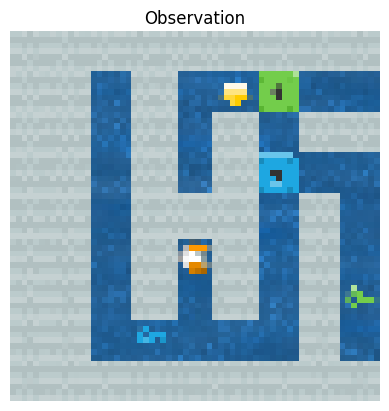

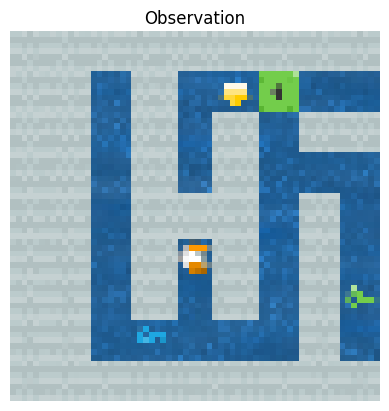

[{'x': StateValue(val=nan, idx=13933), 'y': StateValue(val=nan, idx=13937), 'vx': StateValue(val=0.0, idx=13941), 'vy': StateValue(val=0.0, idx=13945), 'rx': StateValue(val=0.5, idx=13949), 'ry': StateValue(val=0.5, idx=13953), 'type': StateValue(val=1, idx=13957), 'image_type': StateValue(val=1, idx=13961), 'image_theme': StateValue(val=0, idx=13965), 'render_z': StateValue(val=0, idx=13969), 'will_erase': StateValue(val=0, idx=13973), 'collides_with_entities': StateValue(val=0, idx=13977), 'collision_margin': StateValue(val=0.0, idx=13981), 'rotation': StateValue(val=0.0, idx=13985), 'vrot': StateValue(val=0.0, idx=13989), 'is_reflected': StateValue(val=0, idx=13993), 'fire_time': StateValue(val=-1, idx=13997), 'spawn_time': StateValue(val=-1, idx=14001), 'life_time': StateValue(val=0, idx=14005), 'expire_time': StateValue(val=-1, idx=14009), 'use_abs_coords': StateValue(val=0, idx=14013), 'friction': StateValue(val=1.0, idx=14017), 'smart_step': StateValue(val=0, idx=14021), 'avoids

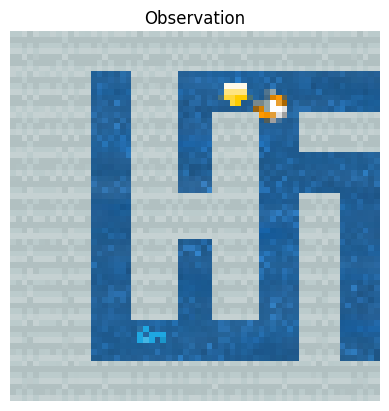

False

In [9]:
model_path = "../model_9501.0.pt"

model = helpers.load_model(model_path=model_path)
layer_number = 14
save_gif = False
episode_timeout = 200
num_levels=1


venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))
state = heist.state_from_venv(venv, 0)
unchanged_obs = venv.reset()
state_values = state.state_vals
key_positions = heist.get_keys(state_values)

while True:
    venv = heist.create_venv(num=1, num_levels=num_levels, start_level=random.randint(1, 10000))

    state = heist.state_from_venv(venv, 0)

    unchanged_obs = venv.reset()

    state_values = state.state_vals

    key_positions = heist.get_keys(state_values)

    if key_positions.get(1) != None:
        print("Green key detected!")
        break

# delete blue key
state.delete_key(0)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_blue_key = venv.reset()

# Add the key back to the environment
print(f"initial: {key_positions}" )

state.set_key_position(0,key_positions[0]["x"],key_positions[0]["y"])
key_positions = heist.get_keys(state_values)


# delete the green key
state.delete_key(1)
state_bytes = state.state_bytes
if state_bytes is not None:
    venv.env.callmethod("set_state", [state_bytes])
    modified_obs_no_green_key = venv.reset()

# Add the key back to the environment
state.set_key_position(1,key_positions[1]["x"], key_positions[1]["y"])

state.delete_specific_locks([0])

state_bytes = state.state_bytes
venv.env.callmethod("set_state", [state_bytes])

state = heist.state_from_venv(venv, 0)
key_positions = heist.get_keys(state.state_vals)
print(f"later: {key_positions}" )


layer_names = helpers.get_model_layer_names(model)
steering_layer_unchanged = ordered_layer_names[layer_number]
steering_layer = helpers.rename_path(steering_layer_unchanged)

model_activations = helpers.ModelActivations(model)
model_activations.clear_hooks()
output1, unmodified_activations = model_activations.run_with_cache(helpers.observation_to_rgb(unchanged_obs), layer_names)
model_activations.clear_hooks()
output2, modified_obs_activations_no_blue = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_blue_key), layer_names)
model_activations.clear_hooks()
output3, modified_obs_activations_no_green = model_activations.run_with_cache(helpers.observation_to_rgb(modified_obs_no_green_key), layer_names)

steering_vector_blue_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_blue[steering_layer][0]

steering_vector_green_key = unmodified_activations[steering_layer][0] - modified_obs_activations_no_green[steering_layer][0]

scaled_steering_vector_blue_key = -2 * steering_vector_blue_key
# scaled_steering_vector_green_key = 1 * steering_vector_green_key

# Combine the scaled steering vectors
# combined_steering_vector = scaled_steering_vector_blue_key + scaled_steering_vector_green_key



modification_value = 1
helpers.plot_single_observation(helpers.tensor_to_image(unchanged_obs))
helpers.plot_single_observation(helpers.tensor_to_image(venv.reset()))

run_episode_with_steering_and_check_target_acquisition(
    venv, model, steering_vector=scaled_steering_vector_blue_key, steering_layer=ordered_layer_names[layer_number],
    modification_value=modification_value, filepath=f'episode_double_steering.gif',
    save_gif=True, episode_timeout=episode_timeout
)



